In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

In [24]:
import itertools
import matplotlib.gridspec as gridspec
import warnings

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import Perceptron
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

#stacking利器：
#绘制学习曲线
from mlxtend.plotting import plot_learning_curves
#画出logistic模型决策边界
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

In [25]:
tips = sns.load_dataset("tips")

In [26]:
cols = ['tip','total_bill', 'sex', 'smoker', 'day', 'time','size']
tips_sub = pd.get_dummies(tips[cols].dropna(), drop_first=True)

X = tips_sub.drop('tip', axis=1)
y = tips_sub.tip

In [27]:
tips_sub

,tip,total_bill,size,sex_Female,smoker_No,day_Fri,day_Sat,day_Sun,time_Dinner
0,1.01,16.99,2,1,1,0,0,1,1
1,1.66,10.34,3,0,1,0,0,1,1
2,3.50,21.01,3,0,1,0,0,1,1
3,3.31,23.68,2,0,1,0,0,1,1
4,3.61,24.59,4,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...
239,5.92,29.03,3,0,1,0,1,0,1
240,2.00,27.18,2,1,0,0,1,0,1
241,2.00,22.67,2,0,0,0,1,0,1
242,1.75,17.82,2,0,1,0,1,0,1


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=11193) # test的数量占总体的0.2

In [29]:
print(X_train)

     total_bill  size  sex_Female  smoker_No  day_Fri  day_Sat  day_Sun  \
35        24.06     3           0          1        0        1        0   
128       11.38     2           1          1        0        0        0   
37        16.93     3           1          1        0        1        0   
174       16.82     2           0          0        0        0        1   
5         25.29     4           0          1        0        0        1   
..          ...   ...         ...        ...      ...      ...      ...   
162       16.21     3           1          1        0        0        1   
33        20.69     4           1          1        0        1        0   
209       12.76     2           1          0        0        1        0   
4         24.59     4           1          1        0        0        1   
145        8.35     2           1          1        0        0        0   

     time_Dinner  
35             1  
128            0  
37             1  
174            1  
5   

In [30]:

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [33]:
'''
# scale y
y_train_copy = y_train

def y_scaler(y):
    y_stdev = np.std(y_train_copy)
    y_mean = np.mean(y_train_copy)
    y_new = (y - y_mean)/y_stdev # 把y也scale了
    
    return y_new


y_train = y_scaler(y_train)
y_test = y_scaler(y_test)
print(y_train)
print(y_test)
'''

'\n# scale y\ny_train_copy = y_train\n\ndef y_scaler(y):\n    y_stdev = np.std(y_train_copy)\n    y_mean = np.mean(y_train_copy)\n    y_new = (y - y_mean)/y_stdev # 把y也scale了\n    \n    return y_new\n\n\ny_train = y_scaler(y_train)\ny_test = y_scaler(y_test)\nprint(y_train)\nprint(y_test)\n'

In [34]:
w_ = np.random.normal(loc = 0, scale = 0.01, size = X_train.shape[1]+1)
# X_train[:,0] = 1  # 3排的矩阵，第一列全是1
# X_test[:,0] = 1  # 3排的矩阵，第一列全是1
e_ = y_train-(w_[0] + X_train.dot(w_[1:]))
lRMSE = np.log(np.sqrt((e_**2).mean())) # log MSE

print(e_)
print()
print(lRMSE)

35     3.567333
128    1.997038
37     3.007530
174    4.036641
5      4.707259
         ...   
162    1.968021
33     2.388841
209    2.208783
4      3.584120
145    1.493897
Name: tip, Length: 122, dtype: float64

1.2182478847014946


In [35]:
w = np.zeros(1+X_train.shape[1])
w_ = w
print(w_)

[0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [36]:
def net_input(X_, w_):    
    return np.dot(X_, w_[1:]) + w_[0] 

def compute_error(y_, X_, w_):
    return y_ - net_input(X_, w_)

In [37]:
def update_weights(y_,X_,w_):
    eta = 0.001
    n_iter = 51
    w_list = []
    
    for i in range(n_iter):
        w_list.append(w_)
        w_[1:] += eta*X_train.T.dot(compute_error(y_train, X_train, w_))
        w_[0] += eta*compute_error(y_train,X_train,w_).sum()
        
        e_ = compute_error(y_train,X_train,w_)
    
    return w_

In [38]:

'''
eta = 0.1**6 # learning rate
counter = 0
d_e = np.inf

lRMSE_list = []
w_list = []

while d_e>0.1**9:
    w_ = w_ + eta*X_train.T.dot(e_)
    e_ = y_train -(X_train.dot(w_)) 
    
    d_e = lRMSE-np.log(np.sqrt((e_**2).mean()))
    counter = counter+1
    
    lRMSE = np.log(np.sqrt((e_**2).mean()))
    lRMSE_list.append(lRMSE)

    w_list.append(w_)
    


df = pd.concat([pd.DataFrame(lRMSE_list)], axis=1)
df.columns = ['lRMSE']
f,ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(lRMSE_list, 'b-') 
ax[0].plot(w_list, 'r-') 

'''

"\neta = 0.1**6 # learning rate\ncounter = 0\nd_e = np.inf\n\nlRMSE_list = []\nw_list = []\n\nwhile d_e>0.1**9:\n    w_ = w_ + eta*X_train.T.dot(e_)\n    e_ = y_train -(X_train.dot(w_)) \n    \n    d_e = lRMSE-np.log(np.sqrt((e_**2).mean()))\n    counter = counter+1\n    \n    lRMSE = np.log(np.sqrt((e_**2).mean()))\n    lRMSE_list.append(lRMSE)\n\n    w_list.append(w_)\n    \n\n\ndf = pd.concat([pd.DataFrame(lRMSE_list)], axis=1)\ndf.columns = ['lRMSE']\nf,ax = plt.subplots(1,2, figsize=(10,4))\nax[0].plot(lRMSE_list, 'b-') \nax[0].plot(w_list, 'r-') \n\n"

In [39]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)
assert((w[1:] - reg.coef_).sum() < 0.01)

<AxesSubplot:>

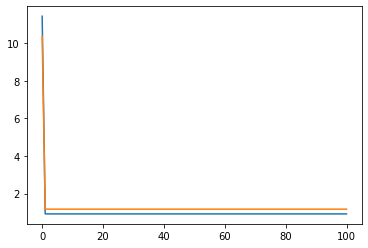

In [40]:
### BEGIN SOLUTION
def MSE(y_,X_,w_):
    return (compute_error(y_, X_, w_)**2).mean()
    
w = np.zeros(1+X_train.shape[1])

MSE_train = [MSE(y_train, X_train, w)]
MSE_test = [MSE(y_test, X_test, w)]

for i in range(100):
    w = update_weights(y_train, X_train, w)
    MSE_train.append(MSE(y_train, X_train, w))
    MSE_test.append(MSE(y_test, X_test, w))
### END SOLUTION

pd.Series(MSE_train).plot()
pd.Series(MSE_test).plot()